In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix,bmat
from scipy.stats import rankdata
import xgboost as xgb
import itertools, gc, json, pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

In [2]:
cols = ['tourn_num','Cat','Distance_from_hole','Strokes_from_starting_location','Permanent_Tournament_#','Year',
        'Course_#','Hole','Player_#','skill_estimate_percentile','not_seen','observation_count_percentile',
        'Green_to_work_with','Par_Value','tourn_num']
data = pd.concat([pd.read_csv('../data/%d.csv.gz' % year,usecols=cols) for year in range(2003,2011)])

In [3]:
data.not_seen = data.not_seen.astype(float)
data.Strokes_from_starting_location = data.Strokes_from_starting_location.astype(float)
data.skill_estimate_percentile = data.skill_estimate_percentile.fillna(.5)
data.observation_count_percentile = data.observation_count_percentile.fillna(.5)

In [4]:
# def prepare_data(cat,num_tourns,with_skill_estimates,with_overall_skill_estimates,with_course_hole,beta=None):
#     num_tournaments = len(pd.unique(data.tourn_num))
#     trains = [range(i) for i in range(num_tournaments-num_tourns-1,num_tournaments-1)]
#     tests = [[i] for i in range(num_tournaments-num_tourns,num_tournaments)]
#     sub = data[data.Cat.isin(cat_map[cat])].reset_index(drop=True)
#     trains = [sub[sub.tourn_num.isin(train)].index.values for train in trains]
#     tests = [sub[sub.tourn_num.isin(test)].index.values for test in tests]
#     cols = ['Distance_from_hole']
#     if cat!='Green': cols += ['Green_to_work_with']
#     if with_skill_estimates: cols += ['skill_estimate_percentile','not_seen','observation_count_percentile']
#     if with_overall_skill_estimates:
#         with open('../PickleFiles/overall_player_quality_%d.json' % (beta,),'r') as json_file:
#             skill_ests = json.loads(json_file.read())
#         skill_ests = {tuple(map(int,key.split('-'))):value for key,value in skill_ests.iteritems()}
#         sub['overall_skill_estimate'] = [skill_ests[tuple(tup)][0] for tup in sub[['Player_#',
#                                                                                    'Permanent_Tournament_#',
#                                                                                    'Year','Par_Value']].values]
#         sub['overall_obs'] = [skill_ests[tuple(tup)][1] for tup in sub[['Player_#',
#                                                                         'Permanent_Tournament_#',
#                                                                         'Year','Par_Value']].values]
#         sub['overall_not_seen'] = np.isnan(sub.overall_skill_estimate.values).astype(float)
#         sub.overall_skill_estimate = sub.skill_estimate_percentile.fillna(.5)
#         sub.overall_obs = sub.observation_count_percentile.fillna(.5)
#         cols += ['overall_skill_estimate','overall_obs','overall_not_seen']
#     X = sub[cols].values
#     y = sub.Strokes_from_starting_location.values
#     if with_course_hole:
#         course_strings = np.array(['%d' % (num,) for num in sub['Course_#']])
#         course_hole_strings = np.array(['%d-%d' % (tup[0],tup[1])
#                                         for tup in sub[['Course_#','Hole']].values])
#     else:
#         course_strings, course_hole_strings = [], []
#     return X,y,course_strings,course_hole_strings,trains,tests

In [4]:
with open('../PickleFiles/num_to_ind_shot.pkl','rb') as pickle_file:
    num_to_ind = pickle.load(pickle_file)

In [5]:
mini_cats = ['tee3','tee45','green0','green5','green10','green20','rough0','rough90',
             'rough375','fairway0','fairway300','fairway540','bunker','other']

def rank(a,mask):
    res = np.ones_like(a)
    res[mask] = rankdata(a[mask])/mask.sum()
    res[~mask] = np.nan
    return res

def prepare_data(cat,num_tourns,with_one_skill_estimate,with_all_skill_estimates,with_player_num,with_course_hole):
    num_tournaments = len(pd.unique(data.tourn_num))
    trains = [range(i) for i in range(num_tournaments-num_tourns-1,num_tournaments-1)]
    tests = [[i] for i in range(num_tournaments-num_tourns,num_tournaments)]
    sub = data[data.Cat.isin(cat_map[cat])].reset_index(drop=True)
    trains = [sub[sub.tourn_num.isin(train)].index.values for train in trains]
    tests = [sub[sub.tourn_num.isin(test)].index.values for test in tests]
    cols = ['Distance_from_hole']
    if cat!='Green': cols += ['Green_to_work_with']
    if with_one_skill_estimate: cols += ['skill_estimate_percentile','not_seen','observation_count_percentile']
    if with_course_hole:
        course_strings = np.array(['%d' % (num,) for num in sub['Course_#']])
        course_hole_strings = np.array(['%d-%d' % (tup[0],tup[1])
                                        for tup in sub[['Course_#','Hole']].values])
    else:
        course_strings, course_hole_strings = [], []
    if with_player_num:
        player_strings = sub['Player_#'].values
    else:
        player_strings = []
    if with_all_skill_estimates:
        for cat_ in mini_cats:
            ranks = np.load('../ranks/ranks-0.8-0.7-0.8-0.94-5/%s_ranks.npy' % (cat_,))
            reps = np.load('../ranks/ranks-0.8-0.7-0.8-0.94-5/%s_reps.npy' % (cat_,))
            mask = np.logical_or(ranks==0,reps==0)
            ranks[mask] = np.nan
            reps[mask] = np.nan
            ranks = np.apply_along_axis(lambda x: rank(x,~np.isnan(x)),0,ranks)
            reps = np.apply_along_axis(lambda x: rank(x,~np.isnan(x)),0,reps)
            sub['rank_%s' % (cat_,)] = [ranks[num_to_ind[pl],tn-1] for pl,tn in sub[['Player_#','tourn_num']].values]
            sub['reps_%s' % (cat_,)] = [reps[num_to_ind[pl],tn-1] for pl,tn in sub[['Player_#','tourn_num']].values]
            sub['not_seen_%s' % (cat_,)] = sub['rank_%s' % (cat_,)].isnull() | sub['reps_%s' % (cat_,)].isnull()
            cols += ['rank_%s' % (cat_,),'reps_%s' % (cat_,),'not_seen_%s' % (cat_,)]
    X = sub[cols].values.astype(np.float64)
    y = sub.Strokes_from_starting_location.values
    return X,y,course_strings,course_hole_strings,player_strings,trains,tests

In [15]:
# def prepare_data(cat,num_tourns,slack,with_skill_estimates,with_player_num,with_course_hole):
#     num_tournaments = len(pd.unique(data.tourn_num))
#     trains = [range(i) for i in range(num_tournaments-num_tourns-1,num_tournaments-1)]
#     tests = [[i] for i in range(num_tournaments-num_tourns,num_tournaments)]
#     sub = data[data.Cat.isin(cat_map[cat])].reset_index(drop=True)
#     trains = [sub[sub.tourn_num.isin(train)].index.values for train in trains]
#     tests = [sub[sub.tourn_num.isin(test)].index.values for test in tests]
#     cols = ['Distance_from_hole']
#     if cat!='Green': cols += ['Green_to_work_with_%d' % (slack,)]
#     if with_skill_estimates: cols += ['skill_estimate_percentile','not_seen','observation_count_percentile']
#     X = sub[cols].values
#     y = sub.Strokes_from_starting_location.values
#     if with_course_hole:
#         course_strings = np.array(['%d' % (num,) for num in sub['Course_#']])
#         course_hole_strings = np.array(['%d-%d' % (tup[0],tup[1])
#                                         for tup in sub[['Course_#','Hole']].values])
#     else:
#         course_strings, course_hole_strings = [], []
#     if with_player_num:
#         player_strings = np.array(['%d' % (num,) for num in sub['Player_#']])
#     else:
#         player_strings = []
#     return X,y,course_strings,course_hole_strings,player_strings,trains,tests

In [6]:
# def psuedo_huber(preds, dtrain):
#     labels = dtrain.get_label()
#     delta = psuedo_huber.delta
#     resids = preds - labels
#     grad = resids * (1 + (resids/delta)**2)**(-.5)
#     hess = (1 + (resids/delta)**2)**(-1.5)
#     return grad, hess

def find_num_trees(X,y,params,eval_pct):
    early_stopping_rounds = 25
    num_round = 10000
    num_train = int(X.shape[0]*(1-eval_pct))
    dtrain = xgb.DMatrix(X[:num_train],label=y[:num_train])
    deval = xgb.DMatrix(X[num_train:],label=y[num_train:])
    watchlist  = [(dtrain,'train'),(deval,'eval')]
    params['base_score'] = y[:num_train].mean()
    bst = xgb.train(params,dtrain,num_round,watchlist,
                    early_stopping_rounds=early_stopping_rounds,verbose_eval=False) 
    return bst.best_iteration

cats = ['Green','Fairway','Rough','Other','Bunker','Tee Box']
cat_map = {'Green':set(['Green']),'Fairway':set(['Fringe','Fairway']),'Bunker':set(['Bunker']),
           'Rough':set(['Primary Rough','Intermediate Rough']),'Other':set(['Other']),'Tee Box':set(['Tee Box'])}
delta_map = {'Green':.6,'Fairway':.9,'Rough':1.05,'Other':1.5,'Bunker':1.05,'Tee Box':1.25}
params = {'objective':'reg:linear','min_child_weight':4,
          'subsample':.75,'tree_method':'approx','silent':1,
          'eta':.05,'lambda':15,'max_depth':9}

def run(cat,num_tourns,with_one_skill_estimate,with_all_skill_estimates,with_player_num,with_course_hole,
        params,eval_pct):
    (X,y,course_strings,course_hole_strings,player_strings,trains,tests) = prepare_data(cat,num_tourns,
                                                                                        with_one_skill_estimate,
                                                                                        with_all_skill_estimates,
                                                                                        with_player_num,
                                                                                        with_course_hole)
    gc.collect()
    
    #psuedo_huber.delta = delta_map[cat]
    if with_course_hole:
        X = csc_matrix(X)
    results = []
    for u,(train,test) in enumerate(zip(trains,tests)):
        gc.collect()
        if with_course_hole or with_player_num:
            X_train, X_test = X.copy()[train], X.copy()[test]
        else:
            X_train, X_test = np.copy(X)[train], np.copy(X)[test]
        if with_player_num:
            lb3 = LabelBinarizer(sparse_output=True)
            X_train = bmat([[X_train,lb3.fit_transform(player_strings[train])]],format='csc')
            X_test = bmat([[X_test,lb3.transform(player_strings[test])]],format='csc')
        if with_course_hole:
            lb1 = LabelBinarizer(sparse_output=True)
            lb2 = LabelBinarizer(sparse_output=True)
            X_train = bmat([[X_train,lb1.fit_transform(course_strings[train]),
                             lb2.fit_transform(course_hole_strings[train])]],format='csc')
            X_test = bmat([[X_test,lb1.transform(course_strings[test]),
                            lb2.transform(course_hole_strings[test])]],format='csc')
        
        if u%8==0:
            #print 'finding_num_trees'
            num_trees = find_num_trees(X_train,y[train],params,eval_pct)
        dtrain = xgb.DMatrix(X_train,label=y[train])
        dtest = xgb.DMatrix(X_test)
        params['base_score'] = y[train].mean()
        bst = xgb.train(params,dtrain,num_trees)
        preds = bst.predict(dtest)
        error = np.mean((preds-y[test])**2)
        mean_error = np.mean((np.mean(y[train])-y[test])**2)
        r_sq = (mean_error-error)/mean_error
        #print len(test),num_trees,r_sq
        results.append(r_sq)
    mean, std_err = np.mean(results), np.std(results)/num_tourns**.5
    return (mean-std_err,mean+std_err)

In [26]:
results = {}
for cat in cats[1:]:
    for slack in range(8,23,2):
        print cat,slack
        res = run(cat,15,slack,False,params,.22)
        print res
        results[(cat,slack)] = res

Fairway 8
(0.33928774074220902, 0.36694465693894163)
Fairway 10
(0.33939533077447553, 0.36708214590545502)
Fairway 12
(0.33949765709202639, 0.36720138080988662)
Fairway 14
(0.33936518256020809, 0.36713107857507121)
Fairway 16
(0.33943184493827866, 0.36717784905189216)
Fairway 18
(0.33942500325098279, 0.36720861093109103)
Fairway 20
(0.33946587097051889, 0.36723312783401069)
Fairway 22
(0.33945275122255131, 0.36724072256257884)
Rough 8
(0.36590330290437384, 0.39803482771916371)
Rough 10
(0.36661282884573582, 0.39869305580604214)
Rough 12
(0.36690523250219581, 0.39897309237973372)
Rough 14
(0.36691572614204454, 0.39907423387977498)
Rough 16
(0.36722057732378061, 0.39933902312079755)
Rough 18
(0.36757315530789747, 0.39966912048755843)
Rough 20
(0.36795846857652453, 0.39996129556093413)
Rough 22
(0.36755091229368408, 0.39963042594380638)
Other 8
(0.16378576879057768, 0.22738587129704643)
Other 10
(0.16331782924313584, 0.22843607481311659)
Other 12
(0.16601417763369203, 0.2267626239484446)


Fairway


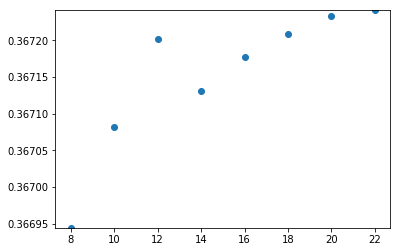

Rough


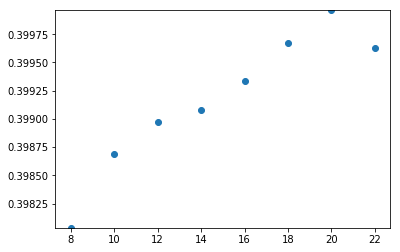

Other


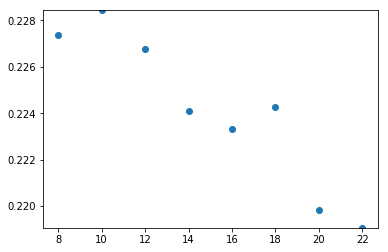

Bunker


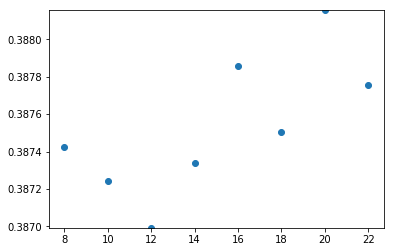

In [36]:
y_ = np.array([])
for cat in cats[1:-1]:
    print cat
    x,y = (np.array([key[1] for key in results.keys() if key[0]==cat]),
           np.array([results[key][1] for key in results.keys() if key[0]==cat]))
    plt.scatter(np.sort(x),y[np.argsort(x)]);
    plt.ylim(np.amin(y),np.amax(y))
    y_ = np.concatenate([y_,y-np.mean(y)])
    plt.show()

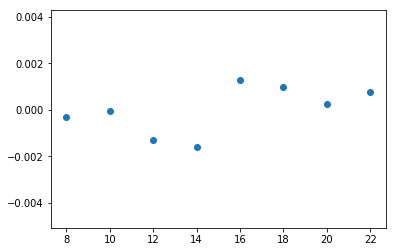

In [41]:
plt.scatter(x,y_.reshape((4,8)).mean(0))
plt.ylim(np.amin(y_),np.amax(y_));

In [55]:
results = {}
results['Green'] = ((0.58976062042512356, 0.59642895108859784),
                    (0.59152030736690209, 0.59815610257623575))
for cat in cats:
    print cat
    if cat!='Green':
        res1 = run(cat,24,16,False,False,False,params,.22)
        print "baseline",res1
        res2 = run(cat,24,16,True,False,False,params,.22)
        print "with_skill_estimates", res2
    res3 = run(cat,24,16,True,True,False,params,.22)
    print "with_player_num",res3
    res4 = run(cat,24,16,True,True,True,params,.22)
    print "with_course_hole",res4
    if cat=='Green':
        results[cat] += (res3,res4)
        continue
    results[cat] = (res1,res2,res3,res4)

Green
with_player_num (0.59159504137265451, 0.59826035688280754)
with_course_hole (0.59181669120703784, 0.59848325462437468)
Fairway
baseline (0.34768046385633061, 0.36948141220287084)
with_skill_estimates (0.35048479092497653, 0.37204877873731679)
with_player_num (0.35096107461967002, 0.37256135154894238)
with_course_hole (0.35491417078870313, 0.37598051625005668)
Rough
baseline (0.37377596518776279, 0.39795682092687101)
with_skill_estimates (0.37588777454603051, 0.40004228028331623)
with_player_num (0.37674181463004863, 0.40092409002823592)
with_course_hole (0.3805135455544198, 0.40478533742223205)
Other
baseline (0.19217943924591702, 0.23655145737596001)
with_skill_estimates (0.19014789138648205, 0.23273227050468995)
with_player_num (0.19098039628998698, 0.23506506111918996)
with_course_hole (0.21966720141308127, 0.27853850998750845)
Bunker
baseline (0.33246257738623008, 0.36104044325785134)
with_skill_estimates (0.336210867839289, 0.36494965876821894)
with_player_num (0.33802032009

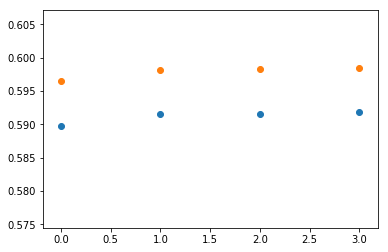

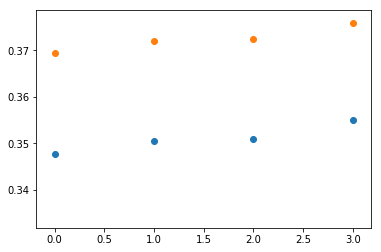

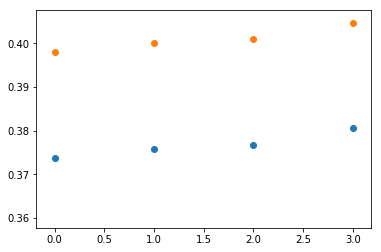

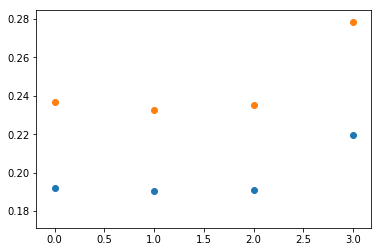

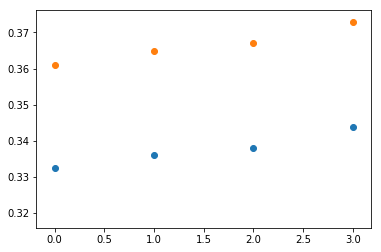

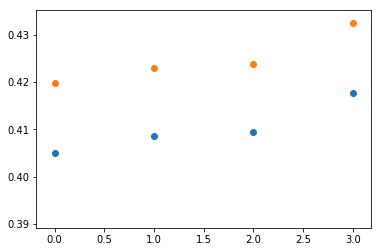

In [56]:
for cat in cats:
    x = range(4)
    y1,y2 = zip(*results[cat])
    plt.scatter(x,y1)
    plt.scatter(x,y2)
    plt.show();

In [17]:
results = {}
for cat in cats:
    for beta in range(15,45,2):
        print cat,beta
        res = run(cat,24,True,True,False,params,.22,beta)
        print res
        results[cat] = res

Green 15
(0.59019744114909334, 0.59694959336131292)
Green 17
(0.59019744114909334, 0.59694959336131292)
Green 19
(0.59019744114909334, 0.59694959336131292)
Green 21
(0.59019744114909334, 0.59694959336131292)
Green 23
(0.59019744114909334, 0.59694959336131292)
Green 25
(0.59019744114909334, 0.59694959336131292)
Green 27
(0.59019744114909334, 0.59694959336131292)
Green 29
(0.59019744114909334, 0.59694959336131292)
Green 31


KeyboardInterrupt: 

In [36]:
run('Green',24,True,False,False,params,.22)

(0.59014760019204959, 0.59687717030839638)

In [37]:
results = {}
for cat in cats[1:]:
    for beta in range(15,45,2):
        print cat,beta
        res = run(cat,24,True,True,False,params,.22,beta)
        print res
        results[cat] = res

Fairway 15
(0.34969343556115162, 0.37135494333171259)
Fairway 17


KeyboardInterrupt: 

In [39]:
from sklearn.model_selection import KFold

In [56]:
def find_num_trees(X,y,params,eval_pct):
    early_stopping_rounds = 25
    num_round = 10000
    num_train = int(X.shape[0]*(1-eval_pct))
    dtrain = xgb.DMatrix(X[:num_train],label=y[:num_train])
    deval = xgb.DMatrix(X[num_train:],label=y[num_train:])
    watchlist  = [(dtrain,'train'),(deval,'eval')]
    params['base_score'] = y[:num_train].mean()
    bst = xgb.train(params,dtrain,num_round,watchlist,
                    early_stopping_rounds=early_stopping_rounds,verbose_eval=False) 
    return bst.best_iteration

params = {'objective':'reg:linear','min_child_weight':4,
          'subsample':.75,'tree_method':'approx','silent':1,
          'eta':.22,'lambda':15,'max_depth':5}

def run(beta):
    data = data[data.Cat=='Green'].copy()
    with open('../PickleFiles/overall_player_quality_%d.json' % (beta,),'r') as json_file:
        skill_ests = json.loads(json_file.read())
    skill_ests = {tuple(map(int,key.split('-'))):value for key,value in skill_ests.iteritems()}
    data['overall_skill_estimate'] = [skill_ests[tuple(tup)][0] for tup in data[['Player_#',
                                                                                 'Permanent_Tournament_#',
                                                                                 'Year','Par_Value']].values]
    data['overall_obs'] = [skill_ests[tuple(tup)][1] for tup in data[['Player_#',
                                                                      'Permanent_Tournament_#',
                                                                      'Year','Par_Value']].values]
    data['overall_not_seen'] = np.isnan(data.overall_skill_estimate.values).astype(float)
    data.overall_skill_estimate = data.skill_estimate_percentile.fillna(.5)
    data.overall_obs = data.observation_count_percentile.fillna(.5)
    y = data.Strokes_from_starting_location.values
    X = data[['Distance_from_hole','overall_skill_estimate','overall_obs','overall_not_seen']].values
    kfold = KFold(n_splits=6,shuffle=True,random_state=4)
    r_sqs = []
    for train,test in kfold.split(X,y):
        num_trees = find_num_trees(X,y,params,.22)
        dtrain = xgb.DMatrix(X[train],label=y[train])
        dtest = xgb.DMatrix(X[test])
        params['base_score'] = y[train].mean()
        bst = xgb.train(params,dtrain,num_trees)
        preds = bst.predict(dtest)
        error = np.mean((preds-y[test])**2)
        mean_error = np.mean((np.mean(y[train])-y[test])**2)
        r_sq = (mean_error-error)/mean_error
        r_sqs.append(r_sq)
    return np.mean(r_sqs)

In [46]:
y = data.Strokes_from_starting_location.values
X = data[['Distance_from_hole','overall_skill_estimate','overall_obs','overall_not_seen']].values

In [47]:
n_trees

19

In [61]:
mask = (data.Cat=='Green').values
n_trees = find_num_trees(X[mask],y[mask],params,.22)
dtrain = xgb.DMatrix(X[mask],label=y[mask])

In [62]:
bst = xgb.train(params,dtrain,n_trees)

In [63]:
preds = bst.predict(dtrain)

In [65]:
np.corrcoef(y[mask],preds)

array([[ 1.        ,  0.76486905],
       [ 0.76486905,  1.        ]])

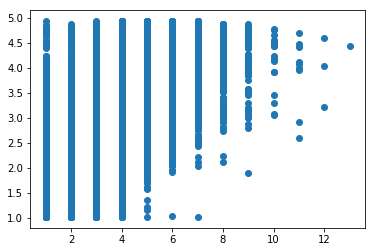

In [54]:
plt.scatter(y,preds)

In [55]:
np.corrcoef(y,preds)

array([[ 1.        ,  0.90653485],
       [ 0.90653485,  1.        ]])

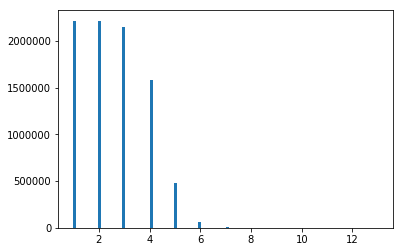

In [45]:
plt.hist(y,bins=100);

In [42]:
for beta in range(15,45,2):
    print run(beta)

0.821730585702
0.821730585702
0.821730585702
0.821730585702
0.821730585702


KeyboardInterrupt: 

Green  
baseline - with one skill est (0.59014760019204959, 0.59687717030839638)  
with all skill ests (0.5925896146819829, 0.59912089395813495)

In [7]:
res3 = run('Green',24,True,True,True,False,params,.22)
print res3

(0.59264242044636906, 0.59916412028535826)


In [8]:
results = {}
for cat in cats[1:]:
    gc.collect()
    print cat
    res1 = run(cat,24,True,False,False,False,params,.22)
    print "baseline - with one skill est",res1
    gc.collect()
    res2 = run(cat,24,True,True,False,False,params,.22)
    print "with all skill ests", res2
    gc.collect()
    res3 = run(cat,24,True,True,True,False,params,.22)
    print "with player num",res3
    results[cat] = (res1,res2,res3)

Fairway
baseline - with one skill est (0.34962469435324084, 0.37126322233581655)
with all skill ests (0.35213665322709542, 0.37352995621115404)
with player num (0.35218040499394865, 0.37359214563468979)
Rough
baseline - with one skill est (0.37508161726201261, 0.39919428237796029)
with all skill ests (0.37782622115094638, 0.40202484579438597)
with player num (0.37761147012311663, 0.40196962579302126)
Other
baseline - with one skill est (0.19177574912647385, 0.23921835279241069)
with all skill ests (0.18211259211967235, 0.23687192234782178)
with player num (0.18791260074488758, 0.2373383124861434)
Bunker
baseline - with one skill est (0.33572215701160407, 0.3647324399740422)
with all skill ests (0.33854268627756451, 0.36754458303778842)
with player num (0.33905217180896274, 0.36831409290167294)
Tee Box
baseline - with one skill est (0.40802611575602415, 0.42245218126239353)
with all skill ests (0.41048844123966061, 0.42479884766977366)
with player num (0.41053426276500055, 0.42491737973

In [10]:
results['Green'] = ((0.59014760019204959, 0.59687717030839638),(0.5925896146819829, 0.59912089395813495),
                    (0.59264242044636906, 0.59916412028535826))

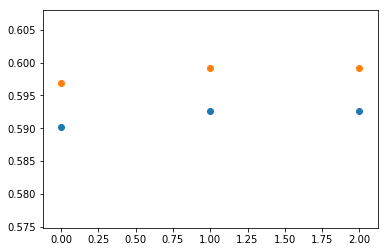

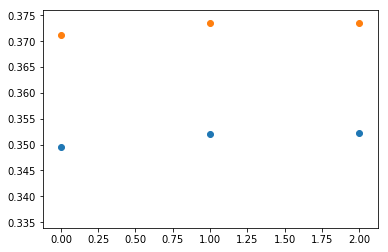

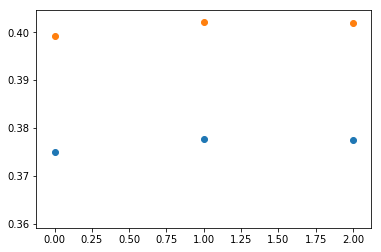

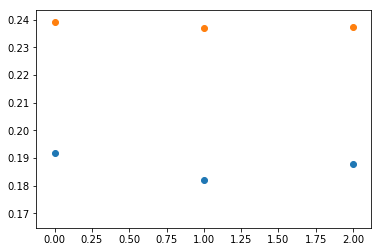

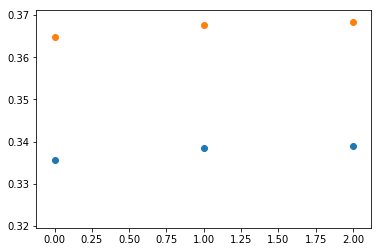

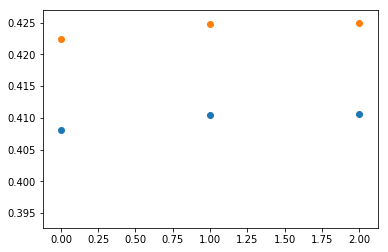

In [11]:
for cat in cats:
    x = range(3)
    y1,y2 = zip(*results[cat])
    plt.scatter(x,y1)
    plt.scatter(x,y2)
    plt.show();